In [2]:
import json
import csv
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap

In [3]:
def analyse(dict_coordo_xyz_labels_r):
    global dict_metriques
    dict_metriques = {'angle_scap_vert' : [], 'angle_scap_prof': [], 'diff_dg': [], 'dejettement': [], 'scoliosis': []}
    
    for im, coordo in dict_coordo_xyz_labels_r.items():
        try:
            scap_y = np.degrees(np.arctan((coordo['ScD'][1] - coordo['ScG'][1])/(coordo['ScD'][0] - coordo['ScG'][0])))
            dict_metriques['angle_scap_vert'].append(scap_y)
            scap_z = np.degrees(np.arctan((coordo['ScG'][2] - coordo['ScD'][2])/(coordo['ScD'][0] - coordo['ScG'][0]))) #ajouter avec z
            dict_metriques['angle_scap_prof'].append(scap_z)

            # calcul distance horizontale entre marqueurs D/G et l'axe du rachis (x=ay+b)
            if 'Linf' in coordo.keys():
                a = (coordo['Linf'][0]-coordo['C7'][0])/(coordo['Linf'][1]-coordo['C7'][1])
            elif 'Tinf' in coordo.keys():
                a = (coordo['Tinf'][0]-coordo['C7'][0])/(coordo['Tinf'][1]-coordo['C7'][1])
            b = coordo['C7'][0] - a*coordo['C7'][1]
            x1 = coordo['ScG'][0]
            x2 = (a*coordo['ScG'][1])+b
            d1 = abs(x1 - x2) #distance entre G et l'axe de la colonne
            x3 = coordo['ScD'][0]
            x4 = a*coordo['ScD'][1]+b
            d2 = abs(x3 - x4) #distance entre D et l'axe de la colonne
            diff_d1d2 = abs(d1 - d2)
            dict_metriques['diff_dg'].append(diff_d1d2)

            dejet = (coordo['ID'][0]+coordo['IG'][0])/2 - coordo['C7'][0]
            dict_metriques['dejettement'].append(dejet)

            a = np.sqrt((coordo['Tsup'][0]-coordo['Tap'][0])**2+(coordo['Tsup'][1]-coordo['Tap'][1])**2)
            b = np.sqrt((coordo['Tap'][0]-coordo['Tinf'][0])**2+(coordo['Tap'][1]-coordo['Tinf'][1])**2)
            c = np.sqrt((coordo['Tsup'][0]-coordo['Tinf'][0])**2+(coordo['Tsup'][1]-coordo['Tinf'][1])**2)
            scoliosis_angle = 180 - np.degrees(np.arccos((a**2+b**2-c**2)/(2*a*b)))
            dict_metriques['scoliosis'].append(scoliosis_angle)
        except KeyError:
            continue

    return dict_metriques

In [15]:
def graph_analyze(autocorrections, nb_im, corrections):
    # Graphiques des metriques calculées selon l'image

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)

    for dict_metriques in autocorrections:
        xaxis = range(1, len(dict_metriques['angle_scap_vert'])+1)
        
        ax1.plot(xaxis, dict_metriques['angle_scap_vert'])
        ax1.set_title("Angle vertical entre les scapulas", fontsize=9)
        ax1.set_ylabel('Angle (degrés)', fontsize=9)
        ax1.set_xlabel("Numéro de l'image", fontsize=9)

        ax2.plot(xaxis, dict_metriques['angle_scap_prof'])
        ax2.set_title("Angle de profondeur entre les scapulas", fontsize=9)
        ax2.set_ylabel('Angle (degrés)', fontsize=9)
        ax2.set_xlabel("Numéro de l'image", fontsize=9)

        ax3.plot(xaxis, dict_metriques['diff_dg'])
        ax3.set_title("|Distance rachis-G - Distance rachis-D|", fontsize=9)
        ax3.set_ylabel('Distance (mm)', fontsize=9)
        ax3.set_xlabel("Numéro de l'image", fontsize=9)
        
        ax4.plot(xaxis, dict_metriques['dejettement'])
        ax4.set_xlabel("Numéro de l'image", fontsize=9)
        ax4.set_title('Déjettement (> 0 = gauche | < 0 = droit)', fontsize=9)
        ax4.set_ylabel('Distance (mm)', fontsize=9)
        
        ax5.plot(xaxis, dict_metriques['scoliosis'])
        ax5.set_xlabel("Numéro de l'image", fontsize=9)
        ax5.set_title('Angle de scoliose', fontsize=9)
        ax5.set_ylabel('180 - Angle (degrés)', fontsize=9)
    
    for dict_coordo_xyz_labels_r, lab, col in zip(corrections.values(), corrections.keys(), ['k', 'tab:purple', 'c', 'tab:gray', 'tab:pink', 'y']):
        moy_metriques = {}
        dict_metriques = analyse(dict_coordo_xyz_labels_r)
        for metrique, valeurs in dict_metriques.items():
            moy_metriques.update({metrique : np.mean(valeurs)})
        ax1.axhline(moy_metriques['angle_scap_vert'], color=col, label=lab)
        ax2.axhline(moy_metriques['angle_scap_prof'], color=col, label=lab)
        ax3.axhline(moy_metriques['diff_dg'], color=col, label=lab)
        ax4.axhline(moy_metriques['dejettement'], color=col, label=lab)
        ax5.axhline(moy_metriques['scoliosis'], color=col, label=lab)

    plt.legend(fontsize=7)
    plt.tight_layout()

{'angle_scap_vert': -1.7346417857991914, 'angle_scap_prof': 8.33270746430082, 'diff_dg': 14.278131867549362, 'dejettement': 14.077883019376113, 'scoliosis': 8.84523996915911}
{'angle_scap_vert': -3.1442790287460953, 'angle_scap_prof': 10.33217212747323, 'diff_dg': 4.681681959272746, 'dejettement': 15.542442579542392, 'scoliosis': 8.303846582757885}
{'angle_scap_vert': -3.2953670451487556, 'angle_scap_prof': 12.980977141965251, 'diff_dg': 6.345323662541484, 'dejettement': 5.277762497327181, 'scoliosis': 8.206595199637487}
{'angle_scap_vert': -2.948651064951437, 'angle_scap_prof': 9.595491421359618, 'diff_dg': 11.585613526376644, 'dejettement': 5.919366637133608, 'scoliosis': 9.229609641902917}
{'angle_scap_vert': -12.696966833238383, 'angle_scap_prof': 11.848498824114767, 'diff_dg': 15.31507224728577, 'dejettement': -17.470509065155547, 'scoliosis': 3.834248353081071}
{'angle_scap_vert': -12.480823188538114, 'angle_scap_prof': 10.423439647268655, 'diff_dg': 19.27759493999725, 'dejetteme

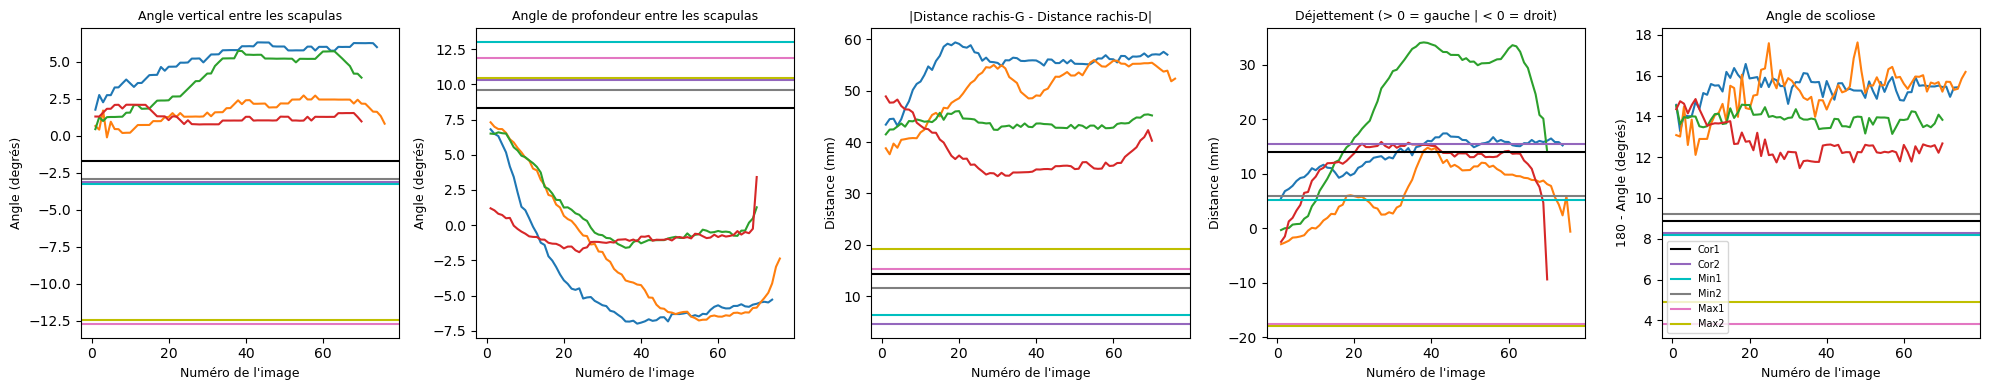

In [20]:
plt.rcParams["figure.figsize"] = (20, 4)

i = 24
path = f'D:/StageE23/Data/Ete_2023/Participant{i}'

corrections = {}
corrs = ['/Corrected/Prise01', '/Corrected/Prise02', '/Minimum/Prise01', '/Minimum/Prise02', '/Maximum/Prise01', '/Maximum/Prise02']
for corr in corrs:
    try:
        dict = json.load(open(path + corr + '/Positions/positions_xyzr.json'))
        corrections.update({corr[1:4]+corr[-1]: dict})
    except FileNotFoundError:
        continue

autocorrections = []
autos = ['/autocorrection/Prise01', '/autocorrection/Prise02', '/autocorrection/Prise03', '/autocorrection/Prise04']
for auto in autos:
    try:
        dict = json.load(open(path + auto + '/Positions/positions_xyzr.json'))
        autocorrections.append(analyse(dict))
    except FileNotFoundError:
        continue

for dict_coordo_xyz_labels_r in corrections.values():
    moy_metriques = {}
    dict_metriques = analyse(dict_coordo_xyz_labels_r)
    for metrique, valeurs in dict_metriques.items():
        moy_metriques.update({metrique : np.mean(valeurs)})

    print(moy_metriques)

#autocorrections = [analyse(auto) for auto in [auto1, auto2, auto3, auto3]]

graph_analyze(autocorrections, len(autocorrections[0]['scoliosis']), corrections)
    